<p><span style="font-size: 16pt;">Worked example isochrone maps to GeoJson</span></p>
<p>This is a worked example we expand on the previous exemple that commes from <a href="https://github.com/gboeing/osmnx-examples/blob/master/notebooks/13-isolines-isochrones.ipynb">https://github.com/gboeing/osmnx-examples/blob/master/notebooks/13-isolines-isochrones.ipynb</a>&nbsp;we now look for a method to convert the UTM encoded shapely shapes to lat long geojson following the guides <a href="https://stackoverflow.com/questions/51486454/convert-geopandas-shapely-polygon-to-geojson">https://stackoverflow.com/questions/51486454/convert-geopandas-shapely-polygon-to-geojson</a>&nbsp; and <a href="https://stackoverflow.com/questions/6778288/lat-lon-to-utm-to-lat-lon-is-extremely-flawed-how-come">https://stackoverflow.com/questions/6778288/lat-lon-to-utm-to-lat-lon-is-extremely-flawed-how-come</a>&nbsp;</p>

In [1]:
import osmnx as ox, networkx as nx, geopandas as gpd, matplotlib.pyplot as plt
from shapely.geometry import Point, LineString, Polygon, mapping
from descartes import PolygonPatch
ox.config(log_console=True, use_cache=True)
import pyproj

In [2]:
# configure the place, network type, trip times, and travel speed
luxembourg_central_station = (49.5999681, 6.1342493)
network_type = 'walk'
trip_times = [15] #in minutes, we could make a differernt polygon for each minute
travel_speed = 4.5 #walking speed in km/hour

In [3]:
# download the street network
G = ox.graph_from_point(luxembourg_central_station, distance=1250, network_type=network_type)

In [4]:
# find the centermost node and then project the graph to UTM
gdf_nodes = ox.graph_to_gdfs(G, edges=False)
x, y = gdf_nodes['geometry'].unary_union.centroid.xy
center_node = ox.get_nearest_node(G, (y[0], x[0]))
G = ox.project_graph(G)

In [5]:
# add an edge attribute for time in minutes required to traverse each edge
meters_per_minute = travel_speed * 1000 / 60 #km per hour to m per minute
for u, v, k, data in G.edges(data=True, keys=True):
    data['time'] = data['length'] / meters_per_minute

In [6]:
# get one color for each isochrone
iso_colors = ox.get_colors(n=len(trip_times), cmap='Reds', start=0.3, return_hex=True)

In [7]:
# make the isochrone polygons
isochrone_polys = []
for trip_time in sorted(trip_times, reverse=True):
    subgraph = nx.ego_graph(G, center_node, radius=trip_time, distance='time')
    node_points = [Point((data['x'], data['y'])) for node, data in subgraph.nodes(data=True)]
    bounding_poly = gpd.GeoSeries(node_points).unary_union.convex_hull
    isochrone_polys.append(bounding_poly)

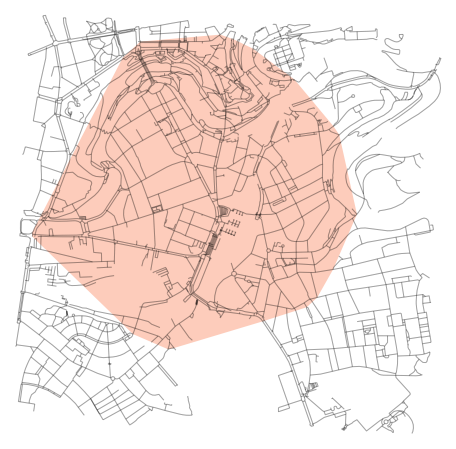

In [8]:
# plot the network then add isochrones as colored descartes polygon patches
fig, ax = ox.plot_graph(G, fig_height=8, show=False, close=False, edge_color='k', edge_alpha=0.2, node_color='none')
for polygon, fc in zip(isochrone_polys, iso_colors):
    patch = PolygonPatch(polygon, fc=fc, ec='none', alpha=0.6, zorder=-1)
    ax.add_patch(patch)
plt.show()

<p><span style="font-size: 16pt;">We now have shapes of isochrones that match node values</span></p>
<p>Now we have to find which nodes match with those polygon shapes</p>

In [9]:
mapping(isochrone_polys[0])

{'type': 'Polygon',
 'coordinates': (((292575.4782030785, 5497329.3063479215),
   (292365.2554784736, 5497422.504883383),
   (291760.095105301, 5498024.262892361),
   (291758.21187150746, 5498047.611641202),
   (292302.90787804197, 5499126.559449185),
   (292409.0812770213, 5499227.115210414),
   (292889.3970736285, 5499270.286599182),
   (292969.73076251545, 5499241.59789318),
   (293086.45665064966, 5499183.6610414125),
   (293335.1374054475, 5498993.914196095),
   (293570.0899898636, 5498704.818319297),
   (293605.27641589276, 5498651.696973181),
   (293711.41778229823, 5498162.017898161),
   (293567.93206416344, 5497821.334187215),
   (293472.7035660724, 5497648.418728848),
   (293409.55820003105, 5497588.282661938),
   (293144.5191994946, 5497500.977835562),
   (292612.465434392, 5497336.788551088),
   (292575.4782030785, 5497329.3063479215)),)}

In [10]:
mapping(isochrone_polys[0])['coordinates']

(((292575.4782030785, 5497329.3063479215),
  (292365.2554784736, 5497422.504883383),
  (291760.095105301, 5498024.262892361),
  (291758.21187150746, 5498047.611641202),
  (292302.90787804197, 5499126.559449185),
  (292409.0812770213, 5499227.115210414),
  (292889.3970736285, 5499270.286599182),
  (292969.73076251545, 5499241.59789318),
  (293086.45665064966, 5499183.6610414125),
  (293335.1374054475, 5498993.914196095),
  (293570.0899898636, 5498704.818319297),
  (293605.27641589276, 5498651.696973181),
  (293711.41778229823, 5498162.017898161),
  (293567.93206416344, 5497821.334187215),
  (293472.7035660724, 5497648.418728848),
  (293409.55820003105, 5497588.282661938),
  (293144.5191994946, 5497500.977835562),
  (292612.465434392, 5497336.788551088),
  (292575.4782030785, 5497329.3063479215)),)

In [11]:
# We isolate the UTM coordinates of the polygon
mapping(isochrone_polys[0])['coordinates'][0][0]

(292575.4782030785, 5497329.3063479215)

In [12]:
# We use pyproj to create a translator from UTM to lat long, as illustrated by user richard in https://stackoverflow.com/questions/6778288/lat-lon-to-utm-to-lat-lon-is-extremely-flawed-how-come
p = pyproj.Proj(proj='utm', zone=32, ellps='WGS84')
x,y = mapping(isochrone_polys[0])['coordinates'][0][0]
p(x,y,inverse=True)

(6.1296913, 49.592922300000005)

In [13]:
# We look at the structure in GeoJson we can get of the polygon method seen in https://stackoverflow.com/questions/51486454/convert-geopandas-shapely-polygon-to-geojson
gpd.GeoSeries([isochrone_polys[0]]).to_json()

'{"type": "FeatureCollection", "features": [{"id": "0", "type": "Feature", "properties": {}, "geometry": {"type": "Polygon", "coordinates": [[[292575.4782030785, 5497329.3063479215], [292365.2554784736, 5497422.504883383], [291760.095105301, 5498024.262892361], [291758.21187150746, 5498047.611641202], [292302.90787804197, 5499126.559449185], [292409.0812770213, 5499227.115210414], [292889.3970736285, 5499270.286599182], [292969.73076251545, 5499241.59789318], [293086.45665064966, 5499183.6610414125], [293335.1374054475, 5498993.914196095], [293570.0899898636, 5498704.818319297], [293605.27641589276, 5498651.696973181], [293711.41778229823, 5498162.017898161], [293567.93206416344, 5497821.334187215], [293472.7035660724, 5497648.418728848], [293409.55820003105, 5497588.282661938], [293144.5191994946, 5497500.977835562], [292612.465434392, 5497336.788551088], [292575.4782030785, 5497329.3063479215]]]}, "bbox": [291758.21187150746, 5497329.3063479215, 293711.41778229823, 5499270.286599182]

In [14]:
# we translate 
new_mapping = []
for i in mapping(isochrone_polys[0])['coordinates'][0]:
    x,y = mapping(isochrone_polys[0])['coordinates'][0][0]
    new_mapping.append(p(x,y,inverse=True))

In [15]:
# we do the same for the bounding box
u, v, w, x = [291758.21187150746, 5497329.3063479215, 293711.41778229823, 5499270.286599182]
newbbox_tuple = [p(u,v,inverse=True),p(w,x,inverse=True)]
newbbox = [newbbox_tuple[0][0],newbbox_tuple[0][1],newbbox_tuple[1][0],newbbox_tuple[1][1]]

In [16]:
# Now we can construct a GeoJson structure with lat long coordinates which we would be able to read using a GeoJason reader or
# on Google Maps

In [17]:
new_geo_json = {"type": "FeatureCollection", "features": [{"id": "0", "type": "Feature", "properties": {}, "geometry": {"type": "Polygon", "coordinates": [new_mapping]}, "bbox": newbbox}], "bbox": newbbox}
print(new_geo_json)

{'type': 'FeatureCollection', 'features': [{'id': '0', 'type': 'Feature', 'properties': {}, 'geometry': {'type': 'Polygon', 'coordinates': [[(6.1296913, 49.592922300000005), (6.1296913, 49.592922300000005), (6.1296913, 49.592922300000005), (6.1296913, 49.592922300000005), (6.1296913, 49.592922300000005), (6.1296913, 49.592922300000005), (6.1296913, 49.592922300000005), (6.1296913, 49.592922300000005), (6.1296913, 49.592922300000005), (6.1296913, 49.592922300000005), (6.1296913, 49.592922300000005), (6.1296913, 49.592922300000005), (6.1296913, 49.592922300000005), (6.1296913, 49.592922300000005), (6.1296913, 49.592922300000005), (6.1296913, 49.592922300000005), (6.1296913, 49.592922300000005), (6.1296913, 49.592922300000005), (6.1296913, 49.592922300000005)]]}, 'bbox': [6.118397137683943, 49.592641451062136, 6.144370652773195, 49.61074761909401]}], 'bbox': [6.118397137683943, 49.592641451062136, 6.144370652773195, 49.61074761909401]}


In [18]:
# Still working on reformating the structure more similar to {'type': 'FeatureCollection', 'features': [{'id': '0', 'type': 'Feature', 'properties': {"fillColor": {"r": 1, "g": 0, "b": 0}}, 'geometry': {'type': 'Polygon', 'coordinates': [[6.1296913, 49.592922300000005], [6.1296913, 49.592922300000005], [6.1296913, 49.592922300000005], [6.1296913, 49.592922300000005], [6.1296913, 49.592922300000005], [6.1296913, 49.592922300000005], [6.1296913, 49.592922300000005], [6.1296913, 49.592922300000005], [6.1296913, 49.592922300000005], [6.1296913, 49.592922300000005], [6.1296913, 49.592922300000005], [6.1296913, 49.592922300000005], [6.1296913, 49.592922300000005], [6.1296913, 49.592922300000005], [6.1296913, 49.592922300000005], [6.1296913, 49.592922300000005], [6.1296913, 49.592922300000005], [6.1296913, 49.592922300000005], [6.1296913, 49.592922300000005]}, 'bbox': [6.118397137683943, 49.592641451062136, 6.144370652773195, 49.61074761909401]}], 'bbox': [6.118397137683943, 49.592641451062136, 6.144370652773195, 49.61074761909401]}
# To be able to ree it on a geojson reader like http://opengeoscience.github.io/geojs/examples/geoJSON/